##  A Simple Implementation of FedAvg

In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot


from pathlib import Path
import requests
import pickle
import gzip

import torch
import math
import torch.nn.functional as F
from torch import nn

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

pd.options.display.float_format = "{:,.4f}".format

loading data

In [25]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training data
trainset = datasets.MNIST('mnist_data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('mnist_data', download=True, train=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


In [26]:
# 加载数据
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28, 28)

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

# 设置数据路径
DATA_PATH = Path("mnist_data")
PATH = DATA_PATH / "MNIST/raw"

# 文件名
train_images_file = PATH / "train-images-idx3-ubyte.gz"
train_labels_file = PATH / "train-labels-idx1-ubyte.gz"
test_images_file = PATH / "t10k-images-idx3-ubyte.gz"
test_labels_file = PATH / "t10k-labels-idx1-ubyte.gz"

x_train = load_mnist_images(train_images_file)
y_train = load_mnist_labels(train_labels_file)
x_test = load_mnist_images(test_images_file)
y_test = load_mnist_labels(test_labels_file)

# 正规化数据
x_train = x_train / 255.0
x_test = x_test / 255.0

# 将训练数据分割为训练集和验证集
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 打印数据集的形状以验证
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (48000, 28, 28), y_train shape: (48000,)
x_valid shape: (12000, 28, 28), y_valid shape: (12000,)
x_test shape: (10000, 28, 28), y_test shape: (10000,)


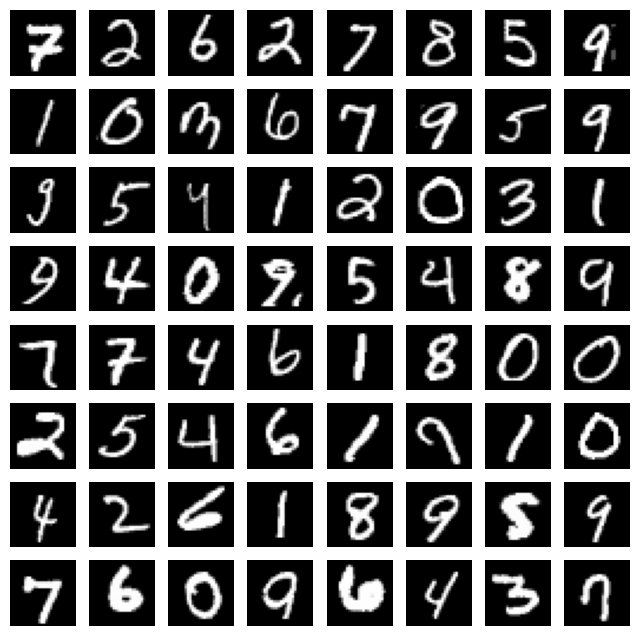

In [27]:
fig, axes = pyplot.subplots(8,8,figsize=(8,8))
for i in range(8):
    for j in range(8):
        num_index = np.random.randint(len(x_train))
        axes[i,j].imshow(x_train[num_index].reshape((28,28)), cmap="gray")
        axes[i,j].axis("off")
pyplot.show() 

**Let's check how many of each tag are**

In [28]:
# Let's check how many of each tag are.
y_train_total=0
y_valid_total=0
y_test_total=0
total=0
for i in range(10):
    print(i,">> train:", sum(y_train==i), ", valid:", sum(y_valid==i), 
          ", test:", sum(y_test==i), ", total:", sum(y_train==i)+sum(y_valid==i)+sum(y_test==i) )
    y_train_total=y_train_total + sum(y_train==i)
    y_valid_total=y_valid_total + sum(y_valid==i)
    y_test_total=y_test_total + sum(y_test==i)
    total=total+sum(y_train==i)+sum(y_valid==i)+sum(y_test==i)
    
print("y_train_total=", y_train_total) 
print("y_valid_total=", y_valid_total) 
print("y_test_total=", y_test_total)
print("total=", total)

0 >> train: 4748 , valid: 1175 , test: 980 , total: 6903
1 >> train: 5420 , valid: 1322 , test: 1135 , total: 7877
2 >> train: 4784 , valid: 1174 , test: 1032 , total: 6990
3 >> train: 4912 , valid: 1219 , test: 1010 , total: 7141
4 >> train: 4666 , valid: 1176 , test: 982 , total: 6824
5 >> train: 4317 , valid: 1104 , test: 892 , total: 6313
6 >> train: 4741 , valid: 1177 , test: 958 , total: 6876
7 >> train: 4966 , valid: 1299 , test: 1028 , total: 7293
8 >> train: 4691 , valid: 1160 , test: 974 , total: 6825
9 >> train: 4755 , valid: 1194 , test: 1009 , total: 6958
y_train_total= 48000
y_valid_total= 12000
y_test_total= 10000
total= 70000


In [29]:
def split_and_shuffle_labels(y_data, seed, amount):
    y_data=pd.DataFrame(y_data,columns=["labels"])
    y_data["i"]=np.arange(len(y_data))
    label_dict = dict()
    for i in range(10):
        var_name="label" + str(i)
        label_info=y_data[y_data["labels"]==i]
        np.random.seed(seed)
        label_info=np.random.permutation(label_info)
        label_info=label_info[0:amount]
        label_info=pd.DataFrame(label_info, columns=["labels","i"])
        label_dict.update({var_name: label_info })
    return label_dict

In [30]:
def get_iid_subsamples_indices(label_dict, number_of_samples, amount):
    sample_dict= dict()
    batch_size=int(math.floor(amount/number_of_samples))
    for i in range(number_of_samples):
        sample_name="sample"+str(i)
        dumb=pd.DataFrame()
        for j in range(10):
            label_name=str("label")+str(j)
            a=label_dict[label_name][i*batch_size:(i+1)*batch_size]
            dumb=pd.concat([dumb,a], axis=0)
        dumb.reset_index(drop=True, inplace=True)    
        sample_dict.update({sample_name: dumb}) 
    return sample_dict

In [31]:
def create_iid_subsamples(sample_dict, x_data, y_data, x_name, y_name):
    x_data_dict= dict()
    y_data_dict= dict()
    
    for i in range(len(sample_dict)):  ### len(sample_dict)= number of samples
        xname= x_name+str(i)
        yname= y_name+str(i)
        sample_name="sample"+str(i)
        
        indices=np.sort(np.array(sample_dict[sample_name]["i"]))
        
        x_info= x_data[indices,:]
        x_data_dict.update({xname : x_info})
        
        y_info= y_data[indices]
        y_data_dict.update({yname : y_info})
        
    return x_data_dict, y_data_dict

--------------------------
### Classification Model

In [32]:
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn, self).__init__()
        # （784， 400） （400，400）（400，10）
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [34]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        data, target = data.float(), target.long()
        
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        

    return train_loss / len(train_loader), correct/len(train_loader.dataset)

In [35]:
def validation(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.float(), target.long()
            
            output = model(data)
            
            test_loss += criterion(output, target).item()
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    return (test_loss, correct)

---------------------------------
### Functions for Federated Averaging </span> 

In [36]:
def create_model_optimizer_criterion_dict(number_of_samples):
    model_dict = dict()
    optimizer_dict= dict()
    criterion_dict = dict()
    
    for i in range(number_of_samples):
        model_name="model"+str(i)
        model_info=Net2nn()
        model_dict.update({model_name : model_info })
        
        optimizer_name="optimizer"+str(i)
        # 改torch.optim.    改优化器
        optimizer_info = torch.optim.SGD(model_info.parameters(), lr=learning_rate, momentum=momentum)
        optimizer_dict.update({optimizer_name : optimizer_info })
        
        criterion_name = "criterion"+str(i)
        
        #改损失函数
        criterion_info = nn.CrossEntropyLoss()
        
        
        criterion_dict.update({criterion_name : criterion_info})
        
    return model_dict, optimizer_dict, criterion_dict 

# Key part

In [37]:
def get_averaged_weights(model_dict, number_of_samples):
   
    fc1_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc1.weight.shape)
    fc1_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc1.bias.shape)
    
    fc2_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc2.weight.shape)
    fc2_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc2.bias.shape)
    
    fc3_mean_weight = torch.zeros(size=model_dict[name_of_models[0]].fc3.weight.shape)
    fc3_mean_bias = torch.zeros(size=model_dict[name_of_models[0]].fc3.bias.shape)
    
    with torch.no_grad():
    
    
        for i in range(number_of_samples):
            fc1_mean_weight += model_dict[name_of_models[i]].fc1.weight.data.clone()
            fc1_mean_bias += model_dict[name_of_models[i]].fc1.bias.data.clone()
        
            fc2_mean_weight += model_dict[name_of_models[i]].fc2.weight.data.clone()
            fc2_mean_bias += model_dict[name_of_models[i]].fc2.bias.data.clone()
        
            fc3_mean_weight += model_dict[name_of_models[i]].fc3.weight.data.clone()
            fc3_mean_bias += model_dict[name_of_models[i]].fc3.bias.data.clone()

        
        fc1_mean_weight =fc1_mean_weight/number_of_samples
        fc1_mean_bias = fc1_mean_bias/ number_of_samples
    
        fc2_mean_weight =fc2_mean_weight/number_of_samples
        fc2_mean_bias = fc2_mean_bias/ number_of_samples
    
        fc3_mean_weight =fc3_mean_weight/number_of_samples
        fc3_mean_bias = fc3_mean_bias/ number_of_samples
    
    return fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias

In [38]:
def set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples):
    fc1_mean_weight, fc1_mean_bias, fc2_mean_weight, fc2_mean_bias, fc3_mean_weight, fc3_mean_bias = get_averaged_weights(model_dict, number_of_samples=number_of_samples)
    with torch.no_grad():
        main_model.fc1.weight.data = fc1_mean_weight.data.clone()
        main_model.fc2.weight.data = fc2_mean_weight.data.clone()
        main_model.fc3.weight.data = fc3_mean_weight.data.clone()

        main_model.fc1.bias.data = fc1_mean_bias.data.clone()
        main_model.fc2.bias.data = fc2_mean_bias.data.clone()
        main_model.fc3.bias.data = fc3_mean_bias.data.clone() 
    return main_model

In [39]:
def compare_local_and_merged_model_performance(number_of_samples):
    accuracy_table=pd.DataFrame(data=np.zeros((number_of_samples,3)), columns=["sample", "local_ind_model", "merged_main_model"])
    for i in range (number_of_samples):
    
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        individual_loss, individual_accuracy = validation(model, test_dl, criterion)
        main_loss, main_accuracy =validation(main_model, test_dl, main_criterion )
    
        accuracy_table.loc[i, "sample"]="sample "+str(i)
        accuracy_table.loc[i, "local_ind_model"] = individual_accuracy
        accuracy_table.loc[i, "merged_main_model"] = main_accuracy

    return accuracy_table

In [40]:
def send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples):
    with torch.no_grad():
        for i in range(number_of_samples):

            model_dict[name_of_models[i]].fc1.weight.data =main_model.fc1.weight.data.clone()
            model_dict[name_of_models[i]].fc2.weight.data =main_model.fc2.weight.data.clone()
            model_dict[name_of_models[i]].fc3.weight.data =main_model.fc3.weight.data.clone() 
            
            model_dict[name_of_models[i]].fc1.bias.data =main_model.fc1.bias.data.clone()
            model_dict[name_of_models[i]].fc2.bias.data =main_model.fc2.bias.data.clone()
            model_dict[name_of_models[i]].fc3.bias.data =main_model.fc3.bias.data.clone() 
    
    return model_dict

In [41]:
def start_train_end_node_process(number_of_samples):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

#         valid_ds = TensorDataset(x_valid_dict[name_of_x_valid_sets[i]], y_valid_dict[name_of_y_valid_sets[i]])
#         valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)
        
        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        print("Subset" ,i)
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
#             valid_loss, valid_accuracy = validation(model, valid_dl, criterion)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
    
            print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))

In [42]:

def start_train_end_node_process_without_print(number_of_samples):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        for epoch in range(numEpoch):        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)

In [43]:
def start_train_end_node_process_print_some(number_of_samples, print_amount):
    for i in range (number_of_samples): 

        train_ds = TensorDataset(x_train_dict[name_of_x_train_sets[i]], y_train_dict[name_of_y_train_sets[i]])
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

        test_ds = TensorDataset(x_test_dict[name_of_x_test_sets[i]], y_test_dict[name_of_y_test_sets[i]])
        test_dl = DataLoader(test_ds, batch_size= batch_size * 2)
    
        model=model_dict[name_of_models[i]]
        criterion=criterion_dict[name_of_criterions[i]]
        optimizer=optimizer_dict[name_of_optimizers[i]]
    
        if i<print_amount:
            print("Subset" ,i)
            
        for epoch in range(numEpoch):
        
            train_loss, train_accuracy = train(model, train_dl, criterion, optimizer)
            test_loss, test_accuracy = validation(model, test_dl, criterion)
            
            if i<print_amount:        
                print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.5f}".format(train_accuracy) + " | test accuracy: {:7.5f}".format(test_accuracy))    

In [44]:
x_train, y_train, x_valid, y_valid,x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))
numEpoch = 10

batch_size = 32
number_of_samples=100


learning_rate = 0.01

momentum = 0.9

train_amount=4500
valid_amount=900
test_amount=900
print_amount=3

### performance of the centralized model

In [45]:
centralized_model = Net2nn()
centralized_optimizer = torch.optim.SGD(centralized_model.parameters(), lr=0.01, momentum=0.9)
centralized_criterion = nn.CrossEntropyLoss()

In [46]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

In [47]:
print("------ Centralized Model ------")
for epoch in range(numEpoch):
    central_train_loss, central_train_accuracy = train(centralized_model, train_dl, centralized_criterion, centralized_optimizer)
    central_test_loss, central_test_accuracy = validation(centralized_model, test_dl, centralized_criterion)
    
    print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.4f}".format(central_train_accuracy) + " | test accuracy: {:7.4f}".format(central_test_accuracy))

print("------ Training finished ------")

------ Centralized Model ------
epoch:   1 | train accuracy:  0.8752 | test accuracy:  0.9482
epoch:   2 | train accuracy:  0.9564 | test accuracy:  0.9645
epoch:   3 | train accuracy:  0.9719 | test accuracy:  0.9672
epoch:   4 | train accuracy:  0.9787 | test accuracy:  0.9747
epoch:   5 | train accuracy:  0.9831 | test accuracy:  0.9757
epoch:   6 | train accuracy:  0.9875 | test accuracy:  0.9727
epoch:   7 | train accuracy:  0.9904 | test accuracy:  0.9766
epoch:   8 | train accuracy:  0.9921 | test accuracy:  0.9777
epoch:   9 | train accuracy:  0.9939 | test accuracy:  0.9764
epoch:  10 | train accuracy:  0.9958 | test accuracy:  0.9784
------ Training finished ------



----------------
-----------------
**Data is distributed to nodes**

In [48]:
label_dict_train=split_and_shuffle_labels(y_data=y_train, seed=1, amount=train_amount) 
sample_dict_train=get_iid_subsamples_indices(label_dict=label_dict_train, number_of_samples=number_of_samples, amount=train_amount)
x_train_dict, y_train_dict = create_iid_subsamples(sample_dict=sample_dict_train, x_data=x_train, y_data=y_train, x_name="x_train", y_name="y_train")


label_dict_valid = split_and_shuffle_labels(y_data=y_valid, seed=1, amount=train_amount) 
sample_dict_valid = get_iid_subsamples_indices(label_dict=label_dict_valid, number_of_samples=number_of_samples, amount=valid_amount)
x_valid_dict, y_valid_dict = create_iid_subsamples(sample_dict=sample_dict_valid, x_data=x_valid, y_data=y_valid, x_name="x_valid", y_name="y_valid")

label_dict_test = split_and_shuffle_labels(y_data=y_test, seed=1, amount=test_amount) 
sample_dict_test = get_iid_subsamples_indices(label_dict=label_dict_test, number_of_samples=number_of_samples, amount=test_amount)
x_test_dict, y_test_dict = create_iid_subsamples(sample_dict=sample_dict_test, x_data=x_test, y_data=y_test, x_name="x_test", y_name="y_test")

torch.Size([450, 28, 28]) torch.Size([450])
torch.Size([90, 28, 28]) torch.Size([90])
torch.Size([90, 28, 28]) torch.Size([90])
tensor(4, dtype=torch.uint8)


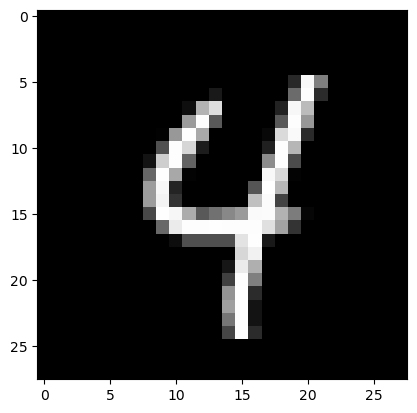

In [51]:
print(x_train_dict["x_train1"].shape, y_train_dict["y_train1"].shape)
print(x_valid_dict["x_valid1"].shape, y_valid_dict["y_valid1"].shape) 
print(x_test_dict["x_test1"].shape, y_test_dict["y_test1"].shape)

num_index = np.random.randint(test_amount/number_of_samples*10)
num_index = 0
pyplot.imshow(x_train_dict["x_train0"][num_index].reshape((28,28)), cmap="gray")
print(y_train_dict["y_train0"][num_index])

**Main model is created**

In [52]:
main_model = Net2nn()
main_optimizer = torch.optim.SGD(main_model.parameters(), lr=learning_rate, momentum=0.9)
main_criterion = nn.CrossEntropyLoss()

**Models,optimizers and loss functions in nodes are defined**

In [53]:
model_dict, optimizer_dict, criterion_dict = create_model_optimizer_criterion_dict(number_of_samples)

**Keys of dicts are being made iterable**

In [54]:
name_of_x_train_sets=list(x_train_dict.keys())
name_of_y_train_sets=list(y_train_dict.keys())
name_of_x_valid_sets=list(x_valid_dict.keys())
name_of_y_valid_sets=list(y_valid_dict.keys())
name_of_x_test_sets=list(x_test_dict.keys())
name_of_y_test_sets=list(y_test_dict.keys())

name_of_models=list(model_dict.keys())
name_of_optimizers=list(optimizer_dict.keys())
name_of_criterions=list(criterion_dict.keys())

# print(name_of_x_train_sets)
# print(name_of_y_train_sets)
# print(name_of_x_valid_sets)
# print(name_of_y_valid_sets)
# print(name_of_x_test_sets)
# print(name_of_y_test_sets)
# print("\n ------------")
# print(name_of_models)
# print(name_of_optimizers)
# print(name_of_criterions)

In [55]:
print(main_model.fc2.weight[0:1,0:5])
print(model_dict["model1"].fc2.weight[0:1,0:5])

tensor([[-0.0078,  0.0646,  0.0403, -0.0702,  0.0474]],
       grad_fn=<SliceBackward0>)
tensor([[ 0.0444, -0.0476,  0.0099, -0.0076,  0.0021]],
       grad_fn=<SliceBackward0>)


**Parameters of main model are sent to nodes**  

In [56]:
model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)

In [57]:
print(main_model.fc2.weight[0:1,0:5])
print(model_dict["model1"].fc2.weight[0:1,0:5])

tensor([[-0.0078,  0.0646,  0.0403, -0.0702,  0.0474]],
       grad_fn=<SliceBackward0>)
tensor([[-0.0078,  0.0646,  0.0403, -0.0702,  0.0474]],
       grad_fn=<SliceBackward0>)


**Models in the nodes are trained**

In [61]:
# start_train_end_node_process()
start_train_end_node_process(number_of_samples)

Subset 0
epoch:   1 | train accuracy: 0.89778 | test accuracy: 0.83333
epoch:   2 | train accuracy: 0.90000 | test accuracy: 0.86667
epoch:   3 | train accuracy: 0.91556 | test accuracy: 0.83333
epoch:   4 | train accuracy: 0.94222 | test accuracy: 0.85556
epoch:   5 | train accuracy: 0.92889 | test accuracy: 0.86667
epoch:   6 | train accuracy: 0.95556 | test accuracy: 0.83333
epoch:   7 | train accuracy: 0.96000 | test accuracy: 0.87778
epoch:   8 | train accuracy: 0.96667 | test accuracy: 0.84444
epoch:   9 | train accuracy: 0.97111 | test accuracy: 0.85556
epoch:  10 | train accuracy: 0.98222 | test accuracy: 0.86667
Subset 1
epoch:   1 | train accuracy: 0.86889 | test accuracy: 0.80000
epoch:   2 | train accuracy: 0.89778 | test accuracy: 0.80000
epoch:   3 | train accuracy: 0.93778 | test accuracy: 0.80000
epoch:   4 | train accuracy: 0.94222 | test accuracy: 0.82222
epoch:   5 | train accuracy: 0.95778 | test accuracy: 0.82222
epoch:   6 | train accuracy: 0.97333 | test accuracy

In [62]:
## As you can see, wieghts of local models are updated after training process
print(main_model.fc2.weight[0,0:5])
print(model_dict["model1"].fc2.weight[0,0:5])

tensor([-0.0078,  0.0646,  0.0403, -0.0702,  0.0474], grad_fn=<SliceBackward0>)
tensor([-0.0078,  0.0613,  0.0363, -0.0704,  0.0464], grad_fn=<SliceBackward0>)


### compare the performance of federated main model, individual local models and centralized model  


In [63]:
before_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples)
before_test_loss, before_test_accuracy = validation(main_model, test_dl, main_criterion)

main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 

after_acc_table=compare_local_and_merged_model_performance(number_of_samples=number_of_samples)
after_test_loss, after_test_accuracy = validation(main_model, test_dl, main_criterion)

In [64]:
print("Federated main model vs individual local models before FedAvg first iteration")
before_acc_table.head()

Federated main model vs individual local models before FedAvg first iteration


,sample,local_ind_model,merged_main_model
0,sample 0,0.8667,0.1222
1,sample 1,0.8333,0.1111
2,sample 2,0.7889,0.0889
3,sample 3,0.8000,0.1000
4,sample 4,0.8222,0.1111


In [65]:
print("Federated main model vs individual local models after FedAvg first iteration")
after_acc_table.head()

Federated main model vs individual local models after FedAvg first iteration


,sample,local_ind_model,merged_main_model
0,sample 0,0.8667,0.9111
1,sample 1,0.8333,0.8556
2,sample 2,0.7889,0.8444
3,sample 3,0.8000,0.8667
4,sample 4,0.8222,0.9222


**Federated main model vs centralized model before 1st iteration (on all test data)**  


In [66]:
print("Before 1st iteration main model accuracy on all test data: {:7.4f}".format(before_test_accuracy))
print("After 1st iteration main model accuracy on all test data: {:7.4f}".format(after_test_accuracy))
print("Centralized model accuracy on all test data: {:7.4f}".format(central_test_accuracy))

Before 1st iteration main model accuracy on all test data:  0.1006
After 1st iteration main model accuracy on all test data:  0.8881
Centralized model accuracy on all test data:  0.9784


In [67]:
Acc_list = []
for i in range(10):
    model_dict=send_main_model_to_nodes_and_update_model_dict(main_model, model_dict, number_of_samples)
    start_train_end_node_process_without_print(number_of_samples)
    main_model= set_averaged_weights_as_main_model_weights_and_update_main_model(main_model,model_dict, number_of_samples) 
    test_loss, test_accuracy = validation(main_model, test_dl, main_criterion)
    print("Iteration", str(i+2), ": main_model accuracy on all test data: {:7.4f}".format(test_accuracy))   
    Acc_list.append()
    
plt.plot(Acc_list)

Iteration 2 : main_model accuracy on all test data:  0.9038
Iteration 3 : main_model accuracy on all test data:  0.9132
Iteration 4 : main_model accuracy on all test data:  0.9209
Iteration 5 : main_model accuracy on all test data:  0.9256
Iteration 6 : main_model accuracy on all test data:  0.9307
Iteration 7 : main_model accuracy on all test data:  0.9347
Iteration 8 : main_model accuracy on all test data:  0.9381
Iteration 9 : main_model accuracy on all test data:  0.9398
Iteration 10 : main_model accuracy on all test data:  0.9419
Iteration 11 : main_model accuracy on all test data:  0.9431


### 
1:data preprocessing #做数据分割，创建子数据集 
2: model从子模型更新->全局模型加权平均->全局模型反过来update子模型->子模型继续更新 
3:central直接模型，main model, local model 比较

补充： 更改Netsize, loss function, SGD -> ADAM